In [85]:
########## Rotation Project: Bi-allelic Simulation over Geography ##########
#   
#   Rowan Hart
#
# Import Dependancies

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import itertools

In [152]:
########## Wright-Fisher Model Simulation Functions ##########

# Function that calculates the Change in Frequency Due to Selection
def sel(F, s_1, s_2):
  mu_sel = F * (1 - F) * (s_1*(1 - 2*F) + s_2)
  return mu_sel

# Function that Calculate the Change in Frequency Due to Migration
def mig(F, m_ij):
  F_T = np.array([F]).T
  mu_mig = np.sum(m_ij*F - m_ij*F_T, axis = 1)
  return mu_mig

# Function that Produces the Variance Matrix
def drift(F, N):
  var = (1 / (2*N)) * F * (1 - F)
  return var

# Function for a single simulation
def sing_biallelic_simulation(para_list):
  F = para_list[0]; N = para_list[1]; s_1 = para_list[2]; s_2 = para_list[3]
  m_ij = para_list[4]; D = para_list[5]; t = para_list[6]; dt = para_list[7]; 
  EPSILON = 10 ** -15
  data = F
  for i in range(int(t / dt)):                            
    mu = (mig(F, m_ij) + sel(F, s_1, s_2))*dt + F          
    std = (drift(F, N)*dt) ** 0.5                         
    F = np.clip(np.random.normal(mu, std), 0, 1)
    data = np.vstack((data, F))
  #  if(np.amax(data[-1]) < EPSILON): return data
  return data

# Function that simulates a number of iterations (not counting loss), counts the fraction lost alleles, and takes the average
def biallelic_simulation(para_list, iter):
  EPSILON = 10 ** -15
  lostA = 0         # Counts the number of lost alleles
  succI = 0         # Counts the number of successfull iterations
  # initialize the array with simulaiton
  total = np.zeros((int(t/dt+1), iter))
  # run until simulations are complete
  while succI < iter:
    current_sim = sing_biallelic_simulation(para_list)
    if(np.amax(current_sim[-1]) < EPSILON): 
      lostA = lostA + 1
    else: 
      total[:, succI] = current_sim.mean(axis=1)
      succI = succI + 1;
  return total

In [87]:
########## Geographic Generation Functions ##########

# Function to create rowXcol indexed coordinates
def idxToCoord_sq(row, col):
  idxToCoordinate = []
  for k in itertools.product(np.arange(col), np.arange(row)):
    idxToCoordinate.append(k)
  return(idxToCoordinate)

# Function to create hex indexed coordinates
def idxToCoord_hx(row, col):
  idxToCoordinate = []
  for k in itertools.product(np.arange(col), np.arange(row)):
    if(sum(k) & 0x1): idxToCoordinate.append(k)
  return(idxToCoordinate)

# Function to build library of coordinates and indexes
def coordToIdx_func(idxToCoordinate):
  coordinateToIdx = {}
  for (idx, k) in enumerate(idxToCoordinate):
    coordinateToIdx[k] = idx
  return(coordinateToIdx)

# Define Neighborhood Migration for Square Coordinates
def neighborhood_migration_sq(idxToCoord, coordToIdx, m_value=0.1):
  D = len(idxToCoord)
  M = np.zeros((D,D))
  for (i,j) in idxToCoord:
    I = coordToIdx[(i,j)]
    N = {(i+1,j), (i-1, j), (i, j+1), (i, j-1)}
    for (k,l) in N:
      if (k,l) in coordToIdx:
        J = coordToIdx[(k,l)]
        M[I,J] = m_value
  return M

# Define Neighborhood Migration for Hexagon Coordinates
def neighborhood_migration_hx(idxToCoord, coordToIdx, m_value=0.1):
  D = len(idxToCoord)
  M = np.zeros((D,D))
  for (i,j) in idxToCoord:
    I = coordToIdx[(i,j)]
    N = {(i+2,j), (i-2, j), (i+1, j+1), (i+1, j-1), (i-1, j-1), (i-1, j+1)}
    for (k,l) in N:
      if (k,l) in coordToIdx:
        J = coordToIdx[(k,l)]
        M[I,J] = m_value
  return M


# Remove a block of individuals from an index (!!USE BEFORE CoordToIDX Function!!)
def idxToCoord_rm_blk(idxToCoord_OG, i1, i2, j1, j2):
  idxToCoordinate = []
  for k in idxToCoord_OG:
    if(not((k[0] >= i1) and (k[0] <= i2) and (k[1] >= j1) and (k[1] <= j2))): idxToCoordinate.append(k)
  return(idxToCoordinate)

# Function for single simulation
def param_init_sing(Finit, N, s_1, s_2, t, dt):
  D = 1
  m_ij = np.full(1, .0)
  F = np.full(1, Finit)
  N = np.full(1, N)
  s_1 = np.full(1, s_1)
  s_2 = np.full(1, s_2)
  return [F, N, s_1, s_2, m_ij, D, t, dt, iter]

# Function for grid simulation parameters
def param_init_sq(Ftot, Ntot, s_1, s_2, m_ij, sqrtD, t, dt):
  idxToCoord = idxToCoord_sq(sqrtD, sqrtD)
  coordToIdx = coordToIdx_func(idxToCoord)
  D = len(idxToCoord)
  m_ij = neighborhood_migration_sq(idxToCoord, coordToIdx, m_value=m_ij)
  F = np.zeros(D)
  F[coordToIdx[(int((sqrtD - 1) / 2), int((sqrtD - 1) / 2))]] = Ftot*D
  N = np.full(D, Ntot / D)
  s_1 = np.full(D, s_1)
  s_2 = np.full(D, s_2)
  return [F, N, s_1, s_2, m_ij, D, t, dt, iter]

# Function for fully connected grid simulation
def param_init_fc_sq(Ftot, Ntot, s_1, s_2, sqrtD, t, dt):
  idxToCoord = idxToCoord_sq(sqrtD, sqrtD)
  coordToIdx = coordToIdx_func(idxToCoord)
  D = len(idxToCoord)
  m_ij = np.full((D,D), 1 / D)
  F = np.full(D, Ftot)
  N = np.full(D, int(Ntot / D))
  s_1 = np.full(D, s_1)
  s_2 = np.full(D, s_2)
  return [F, N, s_1, s_2, m_ij, D, t, dt, iter]

# Function for fully connected grid simulation starting at center
def param_init_fc_sq_cn(Ftot, Ntot, s_1, s_2, sqrtD, t, dt):
  idxToCoord = idxToCoord_sq(sqrtD, sqrtD)
  coordToIdx = coordToIdx_func(idxToCoord)
  D = len(idxToCoord)
  m_ij = np.full((D,D), 1 / D)
  F = np.zeros(D)
  F[coordToIdx[(int((sqrtD - 1) / 2), int((sqrtD - 1) / 2))]] = Ftot*D
  N = np.full(D, int(Ntot / D))
  s_1 = np.full(D, s_1)
  s_2 = np.full(D, s_2)
  return [F, N, s_1, s_2, m_ij, D, t, dt, iter]

In [4]:
########## Random Sampling From Simulations ##########

# Function to Sample From Simulation
def sample_sim(sim, num_samples, samp_size):
  sample_times = np.linspace(0, len(sim) - 1, num_samples, dtype=int)
  freqs = np.zeros((num_samples, samp_size))
  inds = np.zeros((num_samples, samp_size))
  samps = np.zeros(num_samples)
  for i in np.arange(num_samples):
    for j in np.arange(samp_size):
      freqs[i,j] = np.random.choice(sim[sample_times[i]])
      inds[i,j] = np.random.binomial(1, freqs[i,j])
    samps[i] = sum(inds[i]) / samp_size
  return (sample_times, samps)

In [ ]:
# Simple Simulation of Single Population and Square Deme Population
# Set the Global Parameters
F = 0.01             # Sets the global initial frequency
N = 100000            # Sets the Total Population Size
s_1 = 0.01
s_2 = 0.02
t = 300
dt = .1

# Set the Simulation Parameters
# Single Pop
sing_para = param_init_sing(F, N, s_1, s_2, t, dt)
# Multiple Neighborhood Demes
sq_para = param_init_sq(F, N, s_1, s_2, 0.001, 3, t, dt)

sim1 = sing_biallelic_simulation(sing_para)
sim2 = sing_biallelic_simulation(sq_para)

In [ ]:
# Take Random Samples at Different Depths
# Usage: run a simulation and save the data to "sim"
# num_samples are the number of samples across time
# sample_size is the size of each sample
# the function sample_sim(sim, num_samples, sample_size)
# returns two arrays, sample times and the sampled frequencies


s_samp1 = sample_sim(sim1, 100, 10)
sq_samp1 = sample_sim(sim2, 100, 10)
s_samp2 = sample_sim(sim1, 100, 100)
sq_samp2 = sample_sim(sim2, 100, 100)
s_samp3 = sample_sim(sim1, 100, 1000)
sq_samp3 = sample_sim(sim2, 100, 1000)

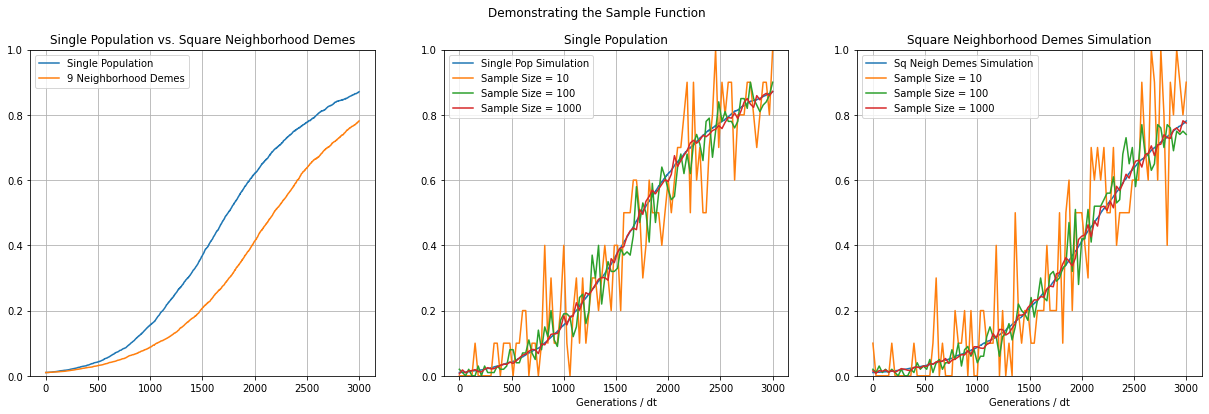

In [ ]:
# Graph the two Populations, along with their samples
x2 = np.linspace(0, int(3000), int((3000)+1))
fig1, axs1 = plt.subplots(1, 3)
fig1.set_size_inches(21, 6)
fig1.suptitle("Demonstrating the Sample Function")
axs1[0].plot(x2, sim1.mean(axis = 1), sim2.mean(axis=1))
axs1[0].set_title("Single Population vs. Square Neighborhood Demes")
axs1[0].set_ylim(0, 1)
axs1[0].grid(True)
axs1[0].legend(['Single Population', '9 Neighborhood Demes'], loc="upper left")
axs1[1].plot(x2, sim1.mean(axis = 1), s_samp1[0], s_samp1[1], s_samp2[0], s_samp2[1], s_samp3[0], s_samp3[1])
axs1[1].set_title("Single Population")
axs1[1].set_ylim(0, 1)
axs1[1].set_xlabel('Generations / dt')
axs1[1].grid(True)
axs1[1].legend(['Single Pop Simulation', 'Sample Size = 10', 'Sample Size = 100', 'Sample Size = 1000'], loc="upper left")
axs1[2].plot(x2, sim2.mean(axis = 1), sq_samp1[0], sq_samp1[1], sq_samp2[0], sq_samp2[1], sq_samp3[0], sq_samp3[1])
axs1[2].set_title("Square Neighborhood Demes Simulation")
axs1[2].set_ylim(0, 1)
axs1[2].set_xlabel('Generations / dt')
axs1[2].grid(True)
axs1[2].legend(['Sq Neigh Demes Simulation', 'Sample Size = 10', 'Sample Size = 100', 'Sample Size = 1000'], loc="upper left")

In [151]:
#### Testing With a Binomial ####

# Function for a single simulation using binomial
def sing_biallelic_simulation_binom(para_list):
  F = para_list[0]; N = para_list[1]; s_1 = para_list[2]; s_2 = para_list[3]
  m_ij = para_list[4]; D = para_list[5]; t = para_list[6]; dt = para_list[7]; 
  EPSILON = 10 ** -10
  data = F
  mu_data = F
  for i in range(int(t)):                            
    mu = (mig(F, m_ij) + sel(F, s_1, s_2)) + F          
    std = (drift(F, N)) ** 0.5
    #F = np.clip(np.random.normal(mu, std), 0, 1)
    F = np.random.binomial(2*N, mu) / (2*N)
    data = np.vstack((data, F))
  return data

# Function that simulates a number of iterations (not counting loss), counts the fraction lost alleles, and takes the average
def biallelic_simulation_binom(para_list, iter):
  t = para_list[6];
  EPSILON = 10 ** -15
  lostA = 0         # Counts the number of lost alleles
  succI = 0         # Counts the number of successfull iterations
  # initialize the array with simulaiton
  total = np.zeros((int(t+1), iter))
  # run until simulations are complete
  for i in np.arange(iter):
    current_sim = sing_biallelic_simulation_binom(para_list)
    total[:, i] = current_sim.mean(axis=1)
  return total

  # Function that simulates a number of iterations (not counting loss), counts the fraction lost alleles, and takes the average
def biallelic_simulation_wl(para_list, iter):
  t = para_list[6];
  EPSILON = 10 ** -15
  # initialize the array with simulaiton
  total = np.zeros((int(t+1), iter))
  # run until simulations are complete
  for i in np.arange(iter):
    current_sim = sing_biallelic_simulation(para_list)
    total[:, i] = current_sim.mean(axis=1)
  return total

In [137]:
freq1 = 0.5
N1 = 100000
std = (drift(freq1, N)) ** 0.5
std

0.001118033988749895

In [169]:
# Binomial Testing w/ ans w/o selection

demes = [1, 3, 5, 7, 9]
results_bin = []
results = []

for d in demes:
    results.append(biallelic_simulation_wl(param_init_fc_sq(.0001, 100000, .0, .0, d, 20, 1), 1000))
    results_bin.append(biallelic_simulation_binom(param_init_fc_sq(.0001, 100000, .0, .0, d, 20, 1), 1000))

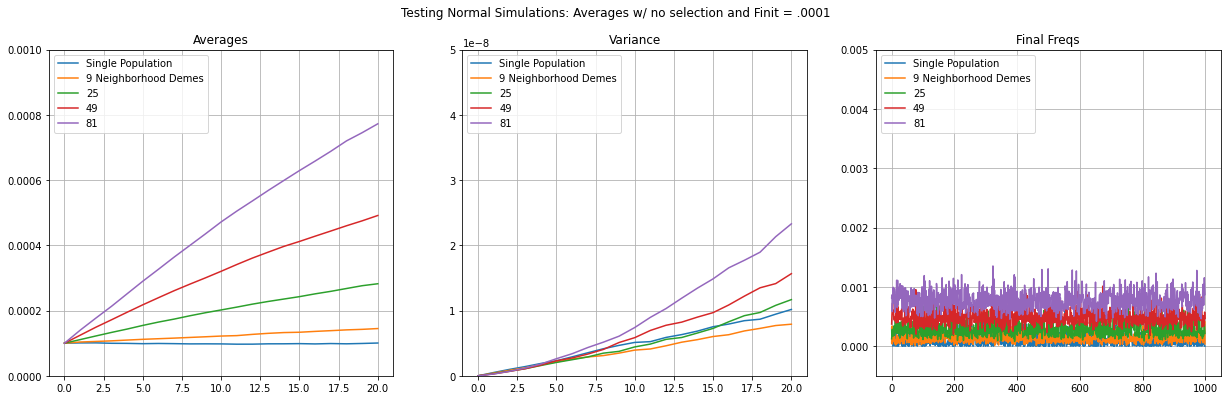

In [177]:
# Graph the two Populations, along with their samples
x2 = np.linspace(0, int(20), int((20)+1))
x1 = np.linspace(0, int(999), 1000)
y = np.average(results[0], axis=1)
fig1, axs1 = plt.subplots(1, 3)
fig1.set_size_inches(21, 6)
fig1.suptitle("Testing Normal Simulations: Averages w/ no selection and Finit = .0001")
axs1[0].plot(x2, results[0].mean(axis = 1), x2,results[1].mean(axis = 1), x2,results[2].mean(axis = 1),x2, results[3].mean(axis = 1), x2,results[4].mean(axis = 1))
axs1[0].set_title("Averages")
axs1[0].set_ylim(0, .001)
axs1[0].grid(True)
axs1[0].legend(['Single Population', '9 Neighborhood Demes', '25', '49', '81'], loc="upper left")
axs1[1].plot(x2, np.var(results[0], axis = 1), x2,np.var(results[1], axis = 1), x2,np.var(results[2], axis = 1),x2, np.var(results[3], axis = 1), x2,np.var(results[4], axis = 1))
axs1[1].set_title("Variance")
axs1[1].set_ylim(0, .00000005)
axs1[1].grid(True)
axs1[1].legend(['Single Population', '9 Neighborhood Demes', '25', '49', '81'], loc="upper left")
axs1[2].plot(x1, results[0][-1], x1,results[1][-1], x1,results[2][-1],x1, results[3][-1], x1,results[4][-1])
axs1[2].set_title("Final Freqs")
axs1[2].set_ylim(-.0005, .005)
axs1[2].grid(True)
axs1[2].legend(['Single Population', '9 Neighborhood Demes', '25', '49', '81'], loc="upper left")

In [164]:
print(sum(results[0][-1] < (10 ** -15)))
print(sum(results[1][-1] < (10 ** -15)))
print(sum(results[2][-1] < (10 ** -15)))
print(sum(results[3][-1] < (10 ** -15)))
print(sum(results[4][-1] < (10 ** -15)))

0
0
0
0
0


In [165]:
print(sum(results_bin[0][-1] < (10 ** -15)))
print(sum(results_bin[1][-1] < (10 ** -15)))
print(sum(results_bin[2][-1] < (10 ** -15)))
print(sum(results_bin[3][-1] < (10 ** -15)))
print(sum(results_bin[4][-1] < (10 ** -15)))

0
0
0
0
0


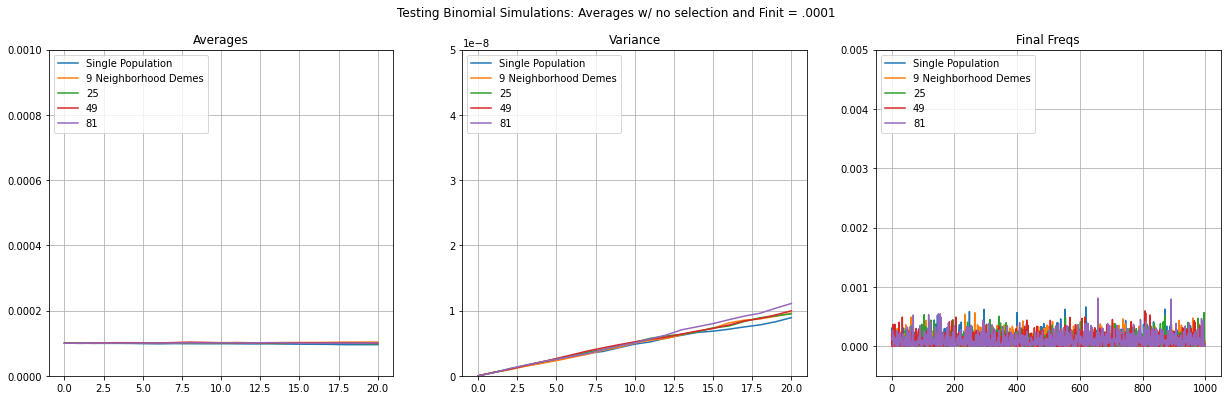

In [179]:
# Graph the two Populations, along with their samples
x2 = np.linspace(0, int(20), int((20)+1))
x1 = np.linspace(0, int(999), 1000)
y = np.average(results[0], axis=1)
fig1, axs1 = plt.subplots(1, 3)
fig1.set_size_inches(21, 6)
fig1.suptitle("Testing Binomial Simulations: Averages w/ no selection and Finit = .0001")
axs1[0].plot(x2, results_bin[0].mean(axis = 1), x2,results_bin[1].mean(axis = 1), x2,results_bin[2].mean(axis = 1),x2, results_bin[3].mean(axis = 1), x2,results_bin[4].mean(axis = 1))
axs1[0].set_title("Averages")
axs1[0].set_ylim(0, .001)
axs1[0].grid(True)
axs1[0].legend(['Single Population', '9 Neighborhood Demes', '25', '49', '81'], loc="upper left")
axs1[1].plot(x2, np.var(results_bin[0], axis = 1), x2,np.var(results_bin[1], axis = 1), x2,np.var(results_bin[2], axis = 1),x2, np.var(results_bin[3], axis = 1), x2,np.var(results_bin[4], axis = 1))
axs1[1].set_title("Variance")
axs1[1].set_ylim(0, .00000005)
axs1[1].grid(True)
axs1[1].legend(['Single Population', '9 Neighborhood Demes', '25', '49', '81'], loc="upper left")
axs1[2].plot(x1, results[0][-1], x1,results_bin[1][-1], x1,results_bin[2][-1],x1, results_bin[3][-1], x1,results_bin[4][-1])
axs1[2].set_title("Final Freqs")
axs1[2].set_ylim(-.0005, .005)
axs1[2].grid(True)
axs1[2].legend(['Single Population', '9 Neighborhood Demes', '25', '49', '81'], loc="upper left")

In [180]:
from scipy.stats import norm as nmd
from scipy.stats import binom as bnd

# Normal for Demes
def deme_norm(freq, N, d):
  Ni = int(N / d)
  d_var = (1 / (2*Ni)) * freq * (1 - freq)
  norm = nmd.cdf(0, loc=freq, scale=d_var**0.5)
  return (norm ** d)

# Binomial for Demes
def deme_binom(freq, N, d):
  Ni = int(N / d)
  binom = bnd.cdf(0, 2*Ni, freq)
  return (binom ** d)

In [181]:
d = [1, 5, 10, 25, 50, 100]

n = []
b = []

for i in d:
  n.append(deme_norm(freq, N, i))
  b.append(deme_binom(freq, N, i))

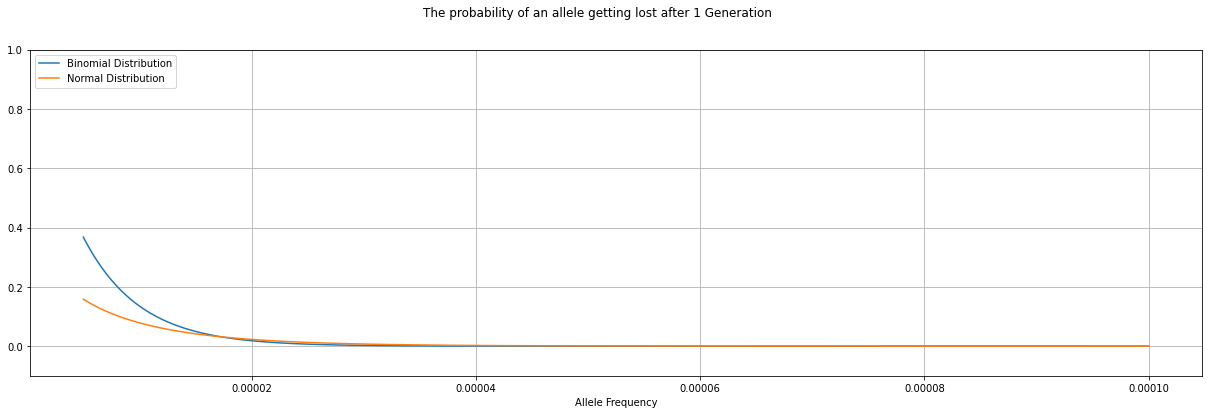

In [182]:
# Single Population Binomial vs. Normal

fig1, axs = plt.subplots(1, 1)
fig1.set_size_inches(21, 6)
fig1.suptitle("The probability of an allele getting lost after 1 Generation")
axs.plot(freq, b[0], freq, n[0])
axs.set_xlabel('Allele Frequency')
axs.set_ylim(-0.1, 1)
axs.grid(True)
axs.legend([ 'Binomial Distribution', 'Normal Distribution'], loc="upper left")

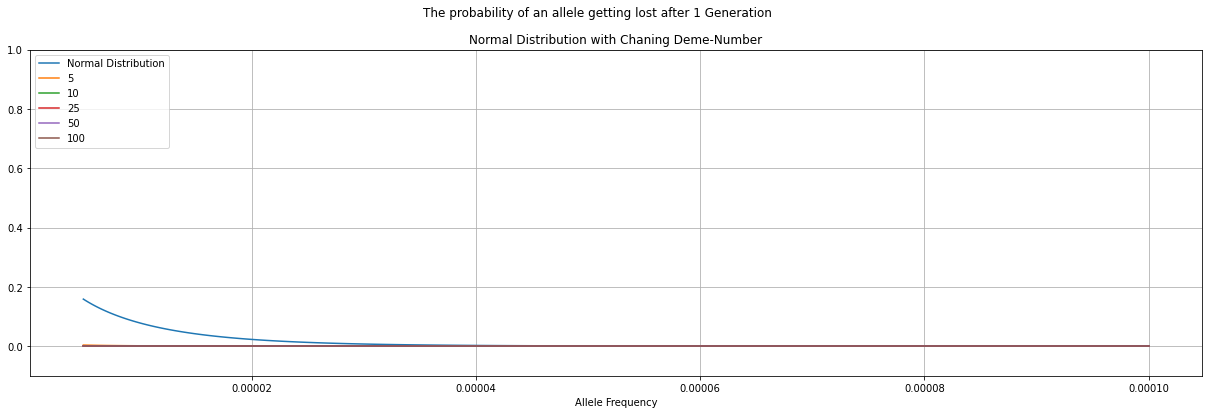

In [183]:
# Changing Deme Number in Normal Distribution

fig1, axs = plt.subplots(1, 1)
fig1.set_size_inches(21, 6)
fig1.suptitle("The probability of an allele getting lost after 1 Generation")
axs.set_title("Normal Distribution with Chaning Deme-Number")
axs.plot(freq, n[0], freq, n[1], freq, n[2], freq, n[3], freq, n[4], freq, n[4])
axs.set_xlabel('Allele Frequency')
axs.set_ylim(-0.1, 1)
axs.grid(True)
axs.legend(['Normal Distribution', d[1], d[2], d[3], d[4], d[5]], loc="upper left")

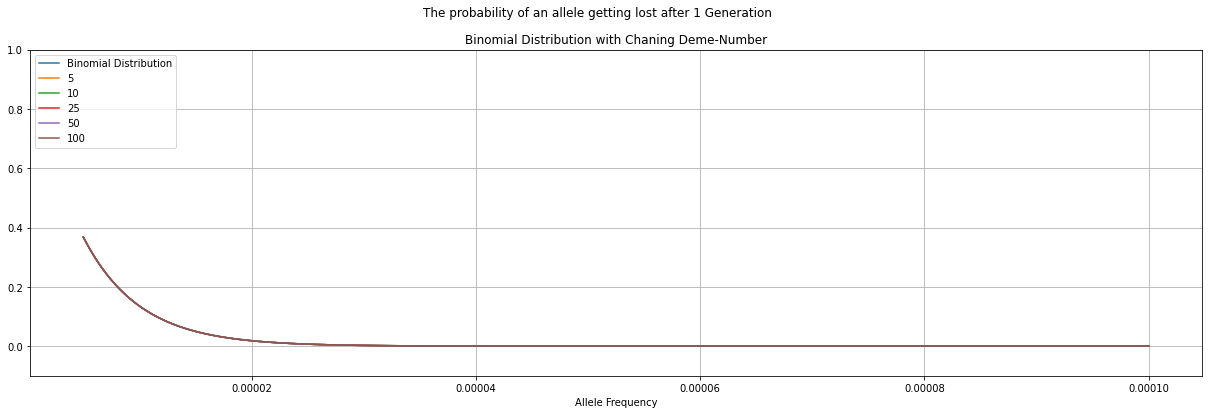

In [150]:
# Changing Deme Number in Binomial Distribution

fig1, axs = plt.subplots(1, 1)
fig1.set_size_inches(21, 6)
fig1.suptitle("The probability of an allele getting lost after 1 Generation")
axs.set_xlabel('Allele Frequency')
axs.set_title("Binomial Distribution with Chaning Deme-Number")
axs.plot(freq, b[0], freq, b[1], freq, b[2], freq, b[3], freq, b[4], freq, b[4])
axs.set_ylim(-0.1, 1)
axs.grid(True)
axs.legend(['Binomial Distribution', d[1], d[2], d[3], d[4], d[5]], loc="upper left")